In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import sys

from stitching import Stitcher, AffineStitcher

sys.path.append('../')
from unwrap_labels.unwrap_labels import LabelUnwrapper

## Read data

In [89]:
sample = 6

imgs_path = os.listdir(f'../data/cv_imgs/{sample}')

imgs = []
for img in sorted(imgs_path):
    to_append = {}
    to_append['img'] = cv2.imread(f'../data/cv_imgs/{sample}/{img}')
    to_append['img_gray'] = cv2.cvtColor(to_append['img'], cv2.COLOR_BGR2GRAY)
    imgs.append(to_append)

In [91]:
imgs = [
    {
        'img': cv2.imread('data/1/IMG_6653.JPG')
    }, 
    {
        'img': cv2.imread('data/1/IMG_6655.JPG')
    }
]

In [92]:
len(imgs)

2

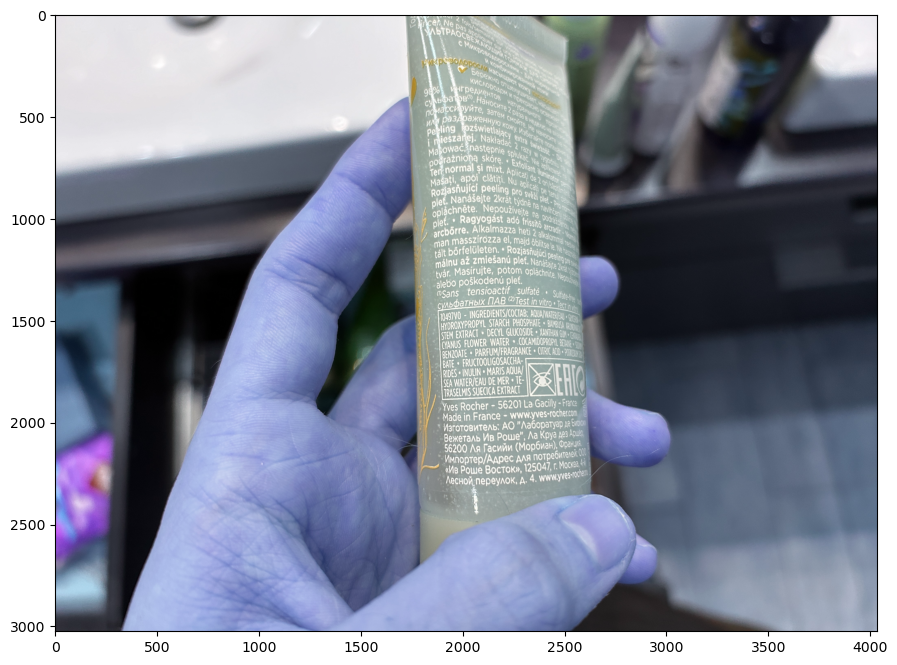

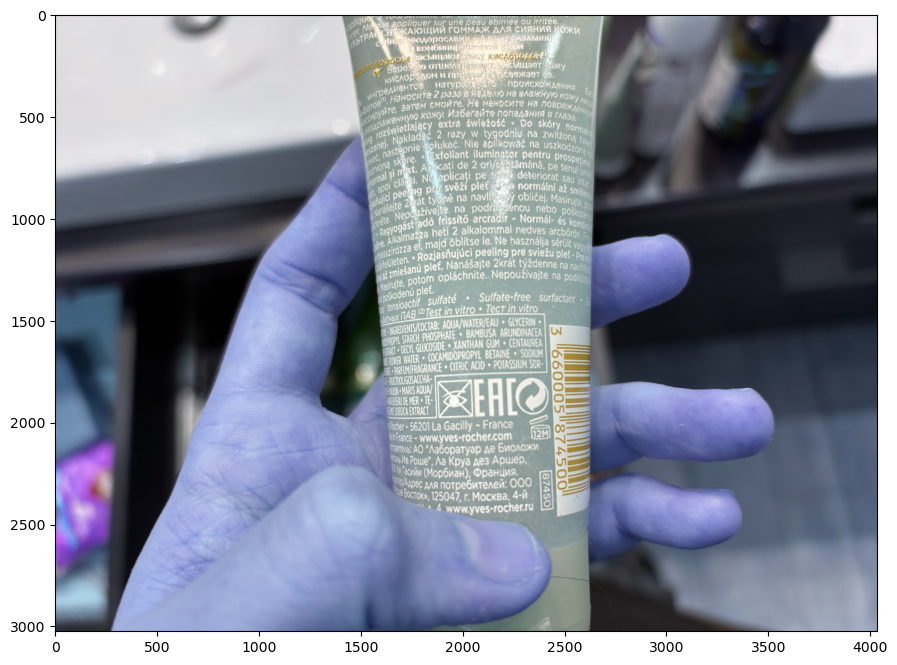

In [93]:
for img in imgs:
    plt.figure(figsize=(15, 8))
    plt.imshow(img['img'], cmap='gray')
    plt.show()


In [6]:
1350 / imgs[1]['img'].shape[0], 1900/ imgs[1]['img'].shape[1]

(0.29094827586206895, 0.5472350230414746)

In [7]:
imgs[1]['img'].shape

(4640, 3472, 3)

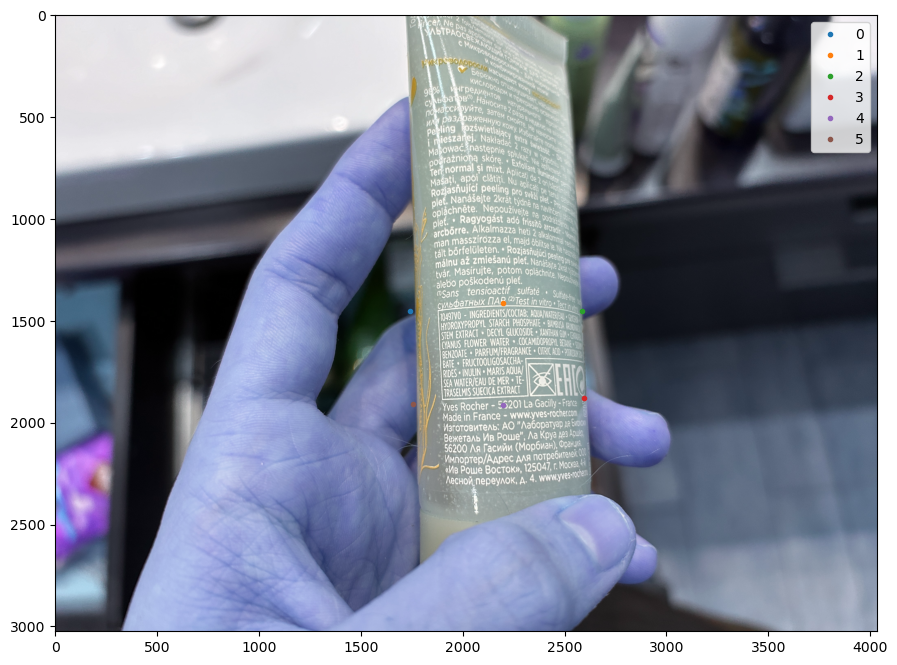

In [121]:
plt.figure(figsize=(15, 8))
plt.imshow(imgs[0]['img'], cmap='gray')

points_1 = [
    {"x": 0.43130952380952384, "y": 0.4794973544973545},
    {"x": 0.5452380952380952, "y": 0.46753703703703703},
    {"x": 0.6411210317460317, "y": 0.47984391534391535},
    {"x": 0.6431051587301587, "y": 0.6216931216931217},
    {"x": 0.5452380952380952, "y": 0.6316931216931217},
    {"x": 0.4350297619047619, "y": 0.6306931216931217}
]

for i, point in enumerate(points_1):
    plt.plot(
        point['x'] * imgs[0]['img'].shape[1],
        point['y'] * imgs[0]['img'].shape[0],
        '.', label = i
    )
    
plt.legend()

plt.show()

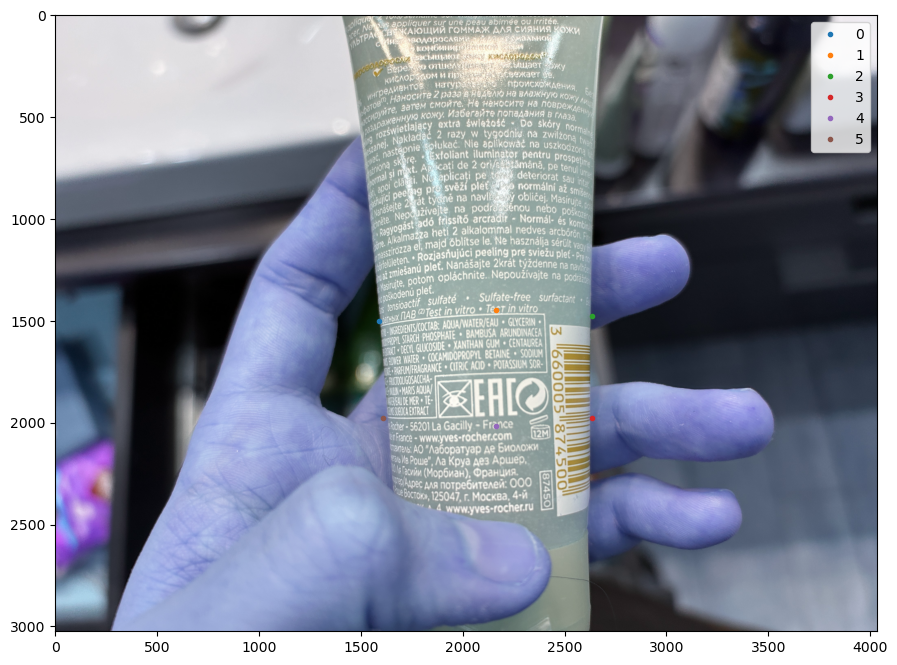

In [132]:
plt.figure(figsize=(15, 8))
plt.imshow(imgs[1]['img'], cmap='gray')

points_2 = [
    {"x": 0.3943452380952381, "y": 0.49603174603174605},
    {"x": 0.53603174603174605, "y": 0.4777645502645503},
    {"x": 0.6535019841269841, "y": 0.4877645502645503},
    {"x": 0.6535019841269841, "y": 0.6531084656084656},
    {"x": 0.53603174603174605, "y": 0.666415343915344},
    {"x": 0.3993055555555556, "y": 0.6531084656084656}
]

for i, point in enumerate(points_2):
    plt.plot(
        point['x'] * imgs[1]['img'].shape[1],
        point['y'] * imgs[1]['img'].shape[0],
        '.', label = i
    )

plt.legend()
plt.show()

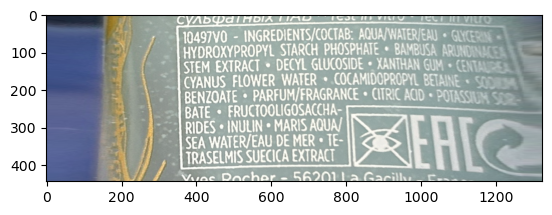

In [122]:
shape = {
    "tag": "label",
    "shape": points_1
}

points_to_plot = []
for point in shape['shape']:
    points_to_plot.append([point['x'], point['y']])

unwrapper = LabelUnwrapper(src_image=imgs[0]['img'], percent_points=points_to_plot)
dst_image_0 = unwrapper.unwrap()

plt.imshow(dst_image_0, cmap='gray')

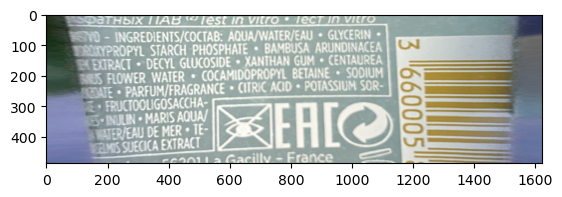

In [133]:
shape = {
    "tag": "label",
    "shape": points_2
}

points = []
for point in shape['shape']:
    points.append([point['x'], point['y']])

unwrapper = LabelUnwrapper(src_image=imgs[1]['img'], percent_points=points)
dst_image_1 = unwrapper.unwrap()

plt.imshow(dst_image_1, cmap='gray')

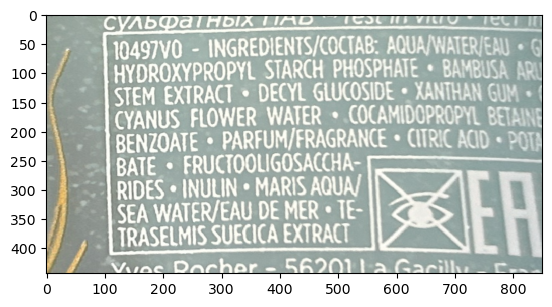

In [173]:
dst_image_0_cut = dst_image_0[:, 250:1100]

plt.imshow(dst_image_0_cut, cmap='gray')

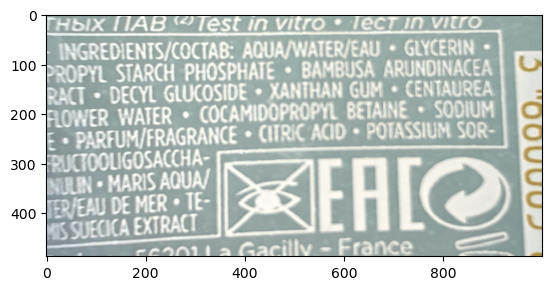

In [174]:
dst_image_1_cut = dst_image_1[:, 200:1200]

plt.imshow(dst_image_1_cut, cmap='gray')

In [175]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)

stitchOut = stitcher.stitch([
    dst_image_0_cut,
    dst_image_1_cut
])

stitchOut

(1, None)

In [176]:
stitcher = Stitcher(detector="sift", confidence_threshold=0.4)

panorama = stitcher.stitch([
    dst_image_0_cut,
    dst_image_1_cut
])

StitchingError: No match exceeds the given confidence threshold.
                                 Do your images have enough overlap and common
                                 features? If yes, you might want to lower the
                                 'confidence_threshold' or try another
                                 'detector'.

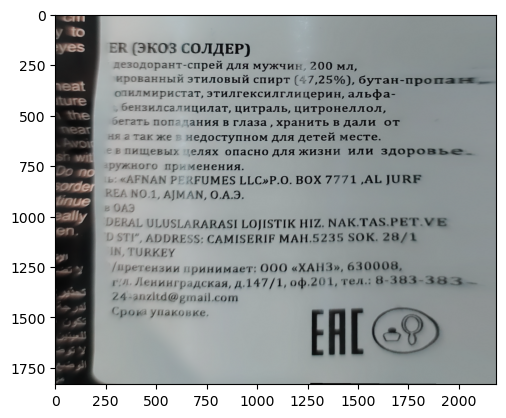

In [137]:
plt.imshow(panorama)

In [189]:
cutted = [
    cv2.cvtColor(dst_image_0_cut, cv2.COLOR_BGR2GRAY),
    cv2.cvtColor(dst_image_1_cut, cv2.COLOR_BGR2GRAY),
]

In [230]:
imgs = [
    {
        'img': cutted[0]
    }, 
    {
        'img': cutted[1]
    }
]

sift = cv2.SIFT_create()

for img in imgs:
    kpts, desc = sift.detectAndCompute(img['img'], None)
    img['keypoints'] = kpts
    img['descriptors'] = desc

KNN = 2
LOWE = 0.75
TREES = 5
CHECKS = 50

matcher = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': TREES}, {'checks': CHECKS})

cur_img = imgs[0]
img = imgs[1]

index_params = dict(
        algorithm=1,  # FLANN_INDEX_KDTREE
        trees=5
    )
search_params = dict(checks=20)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

matches = matcher.knnMatch(cur_img['descriptors'], img['descriptors'], k=KNN)

positive = []
for left_match, right_match in matches:
    if left_match.distance < LOWE * right_match.distance:
        positive.append(left_match)
print(len(positive))

source_keyponts = np.array([cur_img['keypoints'][m.queryIdx].pt for m in positive])
dest_keypoints = np.array([img['keypoints'][m.trainIdx].pt for m in positive])

M, mask = cv2.findHomography(
    source_keyponts,
    dest_keypoints,
    cv2.RANSAC,
    ransacReprojThreshold=.4,
    maxIters=20000,
    confidence=0.995
)

# new_img = cv2.warpPerspective(
#     img['img'], M, (cur_img['img'].shape[1] + img['img'].shape[1], cur_img['img'].shape[0])
# )
# new_img[0:cur_img['img'].shape[0], 0:cur_img['img'].shape[1]] = cur_img['img']

# cur_img['img'] = new_img
#     kpts, desc = sift.detectAndCompute(cur_img['img'], None)
#     cur_img['keypoints'] = kpts
#     cur_img['descriptors'] = desc


878


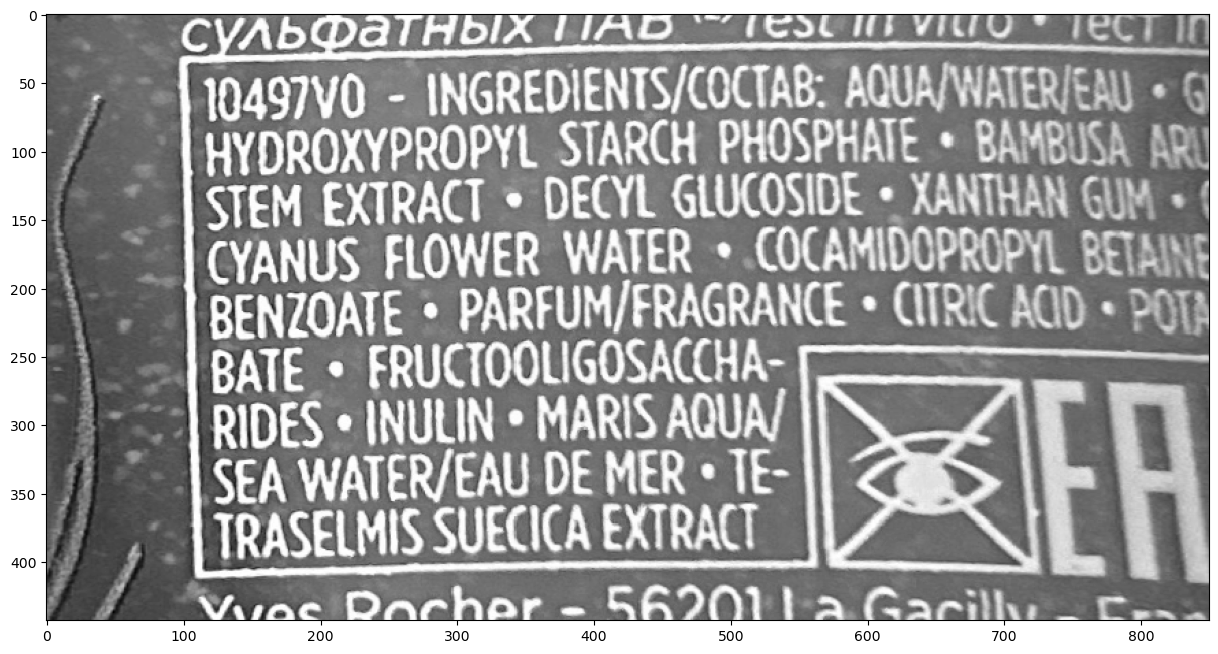

In [231]:
plt.figure(figsize=(15, 8))
plt.imshow(cur_img['img'], cmap='gray')
plt.show()

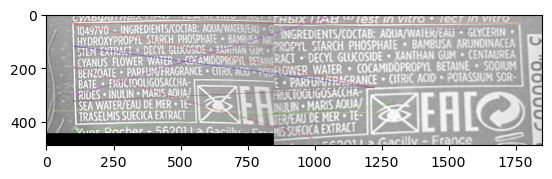

In [232]:
matches_plot = cv2.drawMatches(
    imgs[0]['img'],
    imgs[0]['keypoints'],
    imgs[1]['img'],
    imgs[1]['keypoints'],
    positive[:10], None,flags=2
)

plt.imshow(matches_plot)

In [207]:
result

(1, None)